copied from [gpt.py](https://github.com/karpathy/nanochat/blob/master/nanochat/gpt.py)

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

In [2]:
my_config = GPTConfig(
    sequence_len=7,
    vocab_size=10,
    n_layer=2,
    n_head=2,
    n_kv_head=2,
    n_embd=16,
)

In [3]:
gpt = GPT(my_config); gpt

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(10, 16)
    (h): ModuleList(
      (0-1): 2 x Block(
        (attn): CausalSelfAttention(
          (c_q): Linear(in_features=16, out_features=16, bias=False)
          (c_k): Linear(in_features=16, out_features=16, bias=False)
          (c_v): Linear(in_features=16, out_features=16, bias=False)
          (c_proj): Linear(in_features=16, out_features=16, bias=False)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=16, out_features=64, bias=False)
          (c_proj): Linear(in_features=64, out_features=16, bias=False)
        )
      )
    )
  )
  (lm_head): Linear(in_features=16, out_features=10, bias=False)
)

Think about all the weights to initialize, hand calculate number of params per module, guess initialization method. This is to force me to think before looking at his code.

#### WTE = word token embeddings

In [4]:
# vocab_size number of embeddings each of which is size n_embd
10 * 16

160

Guess? Random numbers from N(0,1). Really have no idea.

What's the [nn.Embedding](https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html) default? N(0,1)

What does ChatGPT say? **Not** to use N(0,1) because "too large, unstable training." It suggests "xavier uniform" where d is the embedding dimension:

$W \sim U\!\left[-\sqrt{\frac{6}{d}},\;\sqrt{\frac{6}{d}}\right]$

So in our toy example we would do uniform random numbers in the range -0.6 to 0.6

#### Causal Self Attention

In [5]:
# n_layers, each with 4 linear transformations, each from n_embd to n_embd, all without bias
2 * 4 * 16 * 16

2048

Guess? No idea. Will again guess random numbers from N(0,1) for all. Maybe there is scaling based on the layer but not even sure in which direction.

What's the [nn.Linear](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html) default?

$\mathcal{U}(-\sqrt{k},\, \sqrt{k})$ where k = 1 / in_features

So in our toy example uniform numbers from -0.25 to 0.25

#### MLP

In [6]:
# n_layers, each fc goes from n_embd to 4 * n_embd, each c_proj goes from 4 * n_embd to n_embd, no bias
2 * (16 * (4 * 16) + (4 * 16) * 16)

4096

Guess? Will guess the nn.Linear default (so one uniform from -0.25 to 0.25 and the other uniform from -0.125 to 0.125. Maybe there is some scaling for layer?

What does ChatGPT say? It has a lot to say! For medium depth GPT-2 like models it says: N(0, (0.2)^2) for both layers.

#### LM_HEAD = language modeling head

In [7]:
# n_embd to vocab_size
16 * 10

160

#### See if counted params right

In [8]:
160 + 2048 + 4096 + 160

6464

In [9]:
sum([p.numel() for p in gpt.parameters()])

6464

#### Look at `init_weights()` and `_init_weights()`

The first thing init_weights does is call `self.apply()` with `_init_weights()` which means `_init_weights()` gets recursively called on every submodule, so let's look at `_init_weights()` first 

In [10]:
def _init_weights(module):
    if isinstance(module, nn.Linear):
        # https://arxiv.org/pdf/2310.17813
        fan_out = module.weight.size(0)  # number of output features
        fan_in = module.weight.size(1)   # number of input features
        std = 1.0 / math.sqrt(fan_in) * min(1.0, math.sqrt(fan_out / fan_in))
        torch.nn.init.normal_(module.weight, mean=0.0, std=std)
        if module.bias is not None:
            torch.nn.init_zeroes_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=1.0)

Well, my initial guess for the embedding was right, unless this gets changed in `init_weights()`.

So for the linear, whenever features in and out is the same, std will be 1 / sqrt(fan_in).

Let's see how std looks for a few pairs of number of in and out features

In [11]:
std = lambda fan_in, fan_out: 1.0 / math.sqrt(fan_in) * min(1.0, math.sqrt(fan_out / fan_in))

In [12]:
std(128, 128), std(128, 512), std(512, 128)

(0.08838834764831843, 0.08838834764831843, 0.022097086912079608)

In [13]:
std(768, 768), std(768, 4 * 768), std(4 * 768, 768)

(0.036084391824351615, 0.036084391824351615, 0.009021097956087904)

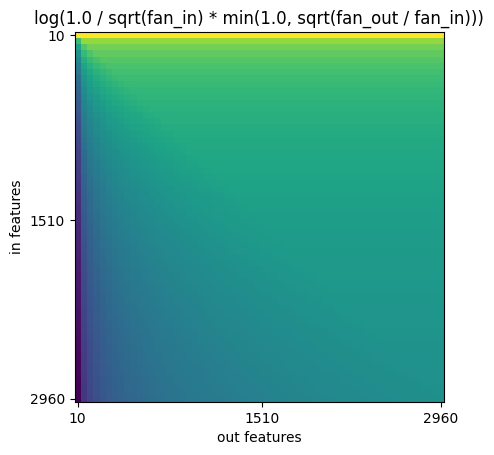

In [14]:
in_features = torch.arange(10, 3000, step=50)
out_features = torch.arange(10, 3000, step=50)
pairs = torch.cartesian_prod(in_features, out_features)
grid = torch.tensor([std(fan_in, fan_out) for fan_in, fan_out in pairs]).reshape((len(in_features), -1))
plt.imshow(grid.log())
plt.xlabel("out features")
plt.ylabel("in features")
plt.title("log(1.0 / sqrt(fan_in) * min(1.0, sqrt(fan_out / fan_in)))")
ticks = [0, len(in_features) // 2, len(in_features) - 1]
plt.yticks(ticks, [in_features[i].item() for i in ticks])
plt.xticks(ticks, [out_features[i].item() for i in ticks])
plt.show()

In [15]:
# 4 corners, clockwise from top left
std(1,1), std(1, 3000), std(3000, 3000), std(3000, 1)

(1.0, 1.0, 0.018257418583505537, 0.0003333333333333333)

#### Back to `init_weights()`

Sanity check, before we apply _init_weights, for the two mlp.c_proj, mean and std are:

In [16]:
gpt.transformer.h[0].mlp.c_proj.weight.mean(), gpt.transformer.h[0].mlp.c_proj.weight.std()

(tensor(0.0024, grad_fn=<MeanBackward0>),
 tensor(0.0722, grad_fn=<StdBackward0>))

In [17]:
gpt.transformer.h[1].mlp.c_proj.weight.mean(), gpt.transformer.h[1].mlp.c_proj.weight.std()

(tensor(0.0011, grad_fn=<MeanBackward0>),
 tensor(0.0711, grad_fn=<StdBackward0>))

In [18]:
gpt.apply(_init_weights);

In [19]:
# After applying we expect a std of around this since it has 64 in features and 16 out features
std(64, 16) # using the lambda from above

0.0625

In [20]:
gpt.transformer.h[0].mlp.c_proj.weight.mean(), gpt.transformer.h[0].mlp.c_proj.weight.std()

(tensor(-0.0001, grad_fn=<MeanBackward0>),
 tensor(0.0623, grad_fn=<StdBackward0>))

In [21]:
gpt.transformer.h[1].mlp.c_proj.weight.mean(), gpt.transformer.h[1].mlp.c_proj.weight.std()

(tensor(-0.0041, grad_fn=<MeanBackward0>),
 tensor(0.0634, grad_fn=<StdBackward0>))

In [22]:
# zero out the classifier weights
torch.nn.init.zeros_(gpt.lm_head.weight);
# why do we do this?

In [23]:
# zero out c_proj weights in all blocks
for block in gpt.transformer.h:
    torch.nn.init.zeros_(block.attn.c_proj.weight)
    torch.nn.init.zeros_(block.mlp.c_proj.weight)
# why do we do this?

In [24]:
# init rotary embeddings
head_dim = gpt.config.n_embd // gpt.config.n_head
cos, sin = gpt._precompute_rotary_embeddings(gpt.rotary_seq_len, head_dim)
gpt.cos, gpt.sin = cos, sin

In [25]:
if gpt.transformer.wte.weight.device.type == "cuda":
    gpt.transformer.wte.to(dtype=torch.bfloat16)

So really we're just initializing the embeddings using standard normal, the q,k,v transformations using normal with the std calc shown above, and zeroing out the rest. Nothing varies based on layer. I don't understand, though, how it can learn at all with, for example, the lm_head zeroed out. Maybe soething after initialization changes the weights again? Figure this out later once I have enough in place to actually train.

Add `_init_weights()` and `init_weights()` to `my_gpt.py`

In [26]:
gpt = GPT(my_config); gpt

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(10, 16)
    (h): ModuleList(
      (0-1): 2 x Block(
        (attn): CausalSelfAttention(
          (c_q): Linear(in_features=16, out_features=16, bias=False)
          (c_k): Linear(in_features=16, out_features=16, bias=False)
          (c_v): Linear(in_features=16, out_features=16, bias=False)
          (c_proj): Linear(in_features=16, out_features=16, bias=False)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=16, out_features=64, bias=False)
          (c_proj): Linear(in_features=64, out_features=16, bias=False)
        )
      )
    )
  )
  (lm_head): Linear(in_features=16, out_features=10, bias=False)
)

Look at weights for two modules before and after init

In [27]:
gpt.lm_head.weight[0,:]

tensor([-0.2109, -0.2433,  0.1584, -0.0566,  0.0747,  0.0862,  0.1512, -0.2283,
         0.2251,  0.2282, -0.2220,  0.0275, -0.1707, -0.0906,  0.1461, -0.2316],
       grad_fn=<SelectBackward0>)

In [28]:
gpt.transformer.h[0].attn.c_q.weight.std()

tensor(0.1433, grad_fn=<StdBackward0>)

In [29]:
gpt.init_weights()

In [30]:
gpt.lm_head.weight[0,:]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)

In [31]:
gpt.transformer.h[0].attn.c_q.weight.std()

tensor(0.2661, grad_fn=<StdBackward0>)